In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

/home/philipp/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def exponential_model(x,a,b,c):
    #return a*np.exp(b*(x-c))
    return a * b**(x+c)

In [3]:
run external_data.py

ModuleNotFoundError: No module named 'arcgis'

In [11]:
#df = get_current_data()
#from database.connection import get_database_table as get_table
#df = get_table()
df = pd.read_csv('database/data.csv')

In [14]:
df.meldedatum = pd.to_datetime(df.meldedatum)

In [15]:
df['Tage'] = df.meldedatum - df.meldedatum.min()
df = df.groupby('Tage').sum()

In [16]:
df.resample('1d').bfill()

,objectid,anzahlfall,anzahltodesfall
Tage,,,
0 days,305016,2,0
1 days,304470,2,0
2 days,457676,3,0
3 days,457676,3,0
4 days,152094,1,0
5 days,152094,1,0
6 days,152094,1,0
7 days,452849,3,0
8 days,152665,1,0


In [18]:
df.set_index('meldedatum').resample('1d').interpolate('linear')

KeyError: "None of ['meldedatum'] are in the columns"

In [19]:
df = df.reset_index()

In [20]:
df.Tage = df.Tage / np.timedelta64(1, 'D')

In [22]:
x = df.Tage
y = df.anzahlfall

fit = curve_fit(exponential_model,x,y,p0=[100,1,1000])
#fit = curve_fit(logistic_model, x, y, p0=[2,100,20000])

/home/philipp/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [23]:
fit[0]

array([4.76391651e-04, 1.13886358e+00, 6.62856679e+01])

Text(0, 0.5, 'cases')

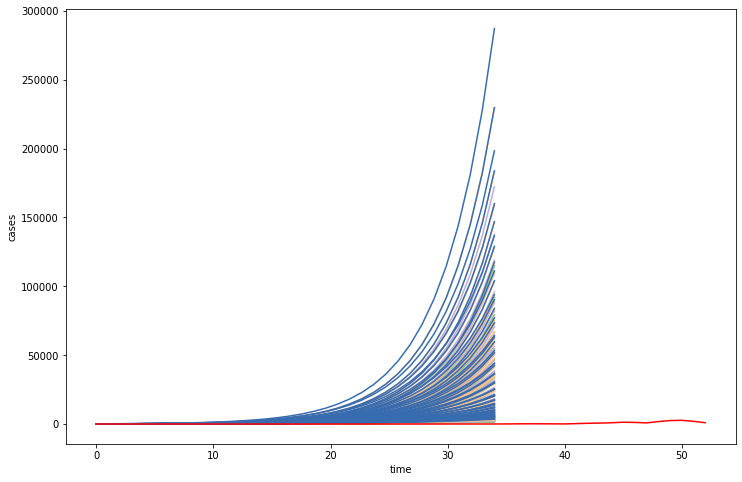

In [30]:
plt.figure(figsize=(12,8))

x = np.linspace(0, len(df.Tage), len(df.Tage))
color_wheel = ['#7fc97f','#beaed4','#fdc086','#386cb0','#ffff99']

a = y[0]
country_coef = [2,3,4,5]
time_delay   = np.arange(8,13,1)
growth_rate  = np.arange(1.15, 1.25, .01)

adam = np.zeros((len(country_coef), len(time_delay), len(growth_rate), len(df.Tage)))

for c, coef in enumerate(country_coef):
    for t, days in enumerate(time_delay):
        for b, rate in enumerate(growth_rate):
            adam[c, t, b, :] = exponential_model(x, coef*a , rate, days)
            plt.plot(x, adam[c, t, b, :], color_wheel[c])

x = df.Tage
y = df.anzahlfall
plt.plot(x, y, 'r', 2, label='Germany')

plt.xlabel('time')
plt.ylabel('cases')
#plt.yscale('log')

AttributeError: 'DataFrame' object has no attribute 'data'

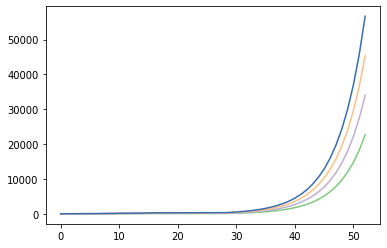

In [31]:
bob = np.mean(adam, axis=(1,2))
for c, coef in enumerate(country_coef):
    plt.plot(x, bob[c, :], color_wheel[c])
            
            
plt.plot(df.data, df.totale_casi, 'r', 2, label='Italy')

plt.xlabel('time')
plt.ylabel('cases')

AttributeError: 'DataFrame' object has no attribute 'data'

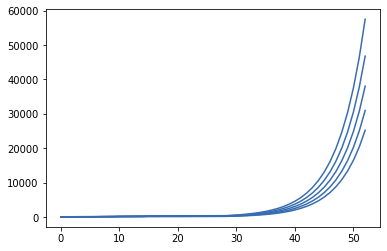

In [27]:
bob = np.mean(adam, axis=(0,2))
for t, days in enumerate(time_delay):
    plt.plot(x, bob[t, :], color_wheel[c])
            
            
plt.plot(df.data, df.totale_casi, 'r', 2, label='Italy')

plt.xlabel('time')
plt.ylabel('cases')

AttributeError: 'DataFrame' object has no attribute 'data'

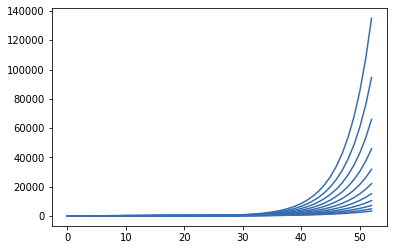

In [28]:
bob = np.mean(adam, axis=(0,1))
for b, rate in enumerate(growth_rate):
    plt.plot(x, bob[b, :], color_wheel[c])

    
plt.plot(df.data, df.totale_casi, 'r', 2, label='Italy')

plt.xlabel('time')
plt.ylabel('cases')

Text(0, 0.5, 'cases')

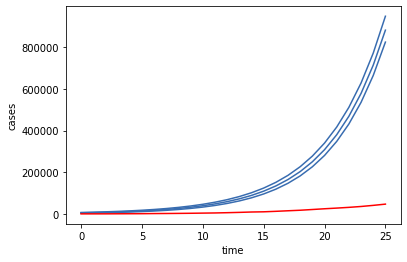

In [28]:
bob = np.mean(adam, axis=(0,1,2))
lb = np.percentile(adam, .25, axis=(0,1,2))
ub = np.percentile(adam, .75, axis=(0,1,2))

plt.plot(x, bob, color_wheel[c])
plt.plot(x, bob - lb, color_wheel[c])
plt.plot(x, bob + ub, color_wheel[c])
    
plt.plot(df.data, df.totale_casi, 'r', 2, label='Italy')

plt.xlabel('time')
plt.ylabel('cases')

In [17]:
bob

array([  4290.52634442,   5220.09871712,   6355.60776905,   7743.59479187,
         9441.30492129,  11519.18644269,  14063.98131079,  17182.54829758,
        21006.59432986,  25698.53203713,  31458.7343407 ,  38534.52261426,
        47231.3067035 ,  57926.39685595,  71086.13430935,  87287.14506335,
       107242.71788416, 131835.55243687, 162158.42855195, 199564.72792751,
       245731.21367165, 302736.0642599 , 373155.8957755 , 460186.42601023,
       567792.5814831 , 700895.28035395])